In [1]:
import torch
import torch.nn as nn
import math

# Model

In [2]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model:int, vocabulary_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocabulary_size
        self.embedding = nn.Embedding(vocabulary_size, d_model)
    def forward(self,x):
        return self.embedding(x) * math.sqrt(self.d_model)


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, sequence_len:int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = sequence_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(sequence_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, sequence_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)
    def forward(self,x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

In [4]:
class LayerNormalization(nn.Module):

    def __init__(self, parameters_shape: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(parameters_shape)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(parameters_shape)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [5]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2
        self.relu = nn.ReLU()

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)

        return x


In [6]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)

In [7]:
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            x = self.norm(x)
            x = self.dropout(sublayer(x)) + x
            return x + self.dropout(sublayer(self.norm(x)))

In [8]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [9]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


In [10]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [11]:
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)


In [12]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

In [13]:

class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)
    

In [14]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N_layers: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N_layers):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N_layers):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    
    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer

# Train

In [ ]:
# from model import build_transformer
# from dataset import BilingualDataset, causal_mask
# from config import get_config, get_weights_file_path

# import torchtext.datasets as datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR

import warnings
from tqdm import tqdm
import os
from pathlib import Path

# Huggingface datasets and tokenizers
from datasets import load_dataset,DatasetDict
import datasets
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import math
import wandb
wandb.login(key="5364c808c25399d37be50f8e9227b609dad82d1b")
import torchmetrics

c:\Users\kainak0\Documents\gitProjects\mia\MIA-203_redes_neuronales\final\translatepy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: j-callomamani-b (salcantaratnaist). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kainak0\_netrc


In [16]:
ds = load_dataset("allenai/nllb", "quy_Latn-spa_Latn")

Repo card metadata block was not found. Setting CardData to empty.


In [17]:
ds['train']['translation'][0]

{'quy_Latn': '- Huk llaqtapin karan huk juez Diosta mana manchakuq, hinallataq runakunatapas mana respetaq.',
 'spa_Latn': 'Y dijo: Había un juez en una ciudad que no temía a Dios ni respetaba a los hombres.'}

In [18]:
ds_raw = {}

In [19]:
ds_raw['qu'] = [x['quy_Latn'] for x in ds['train']['translation']]

In [20]:
ds_raw['es'] = [x['spa_Latn'] for x in ds['train']['translation']]

In [21]:
len(ds_raw['es'])

748091

In [22]:
ds_raw = datasets.Dataset.from_dict(ds_raw)

In [23]:
ds_raw

Dataset({
    features: ['qu', 'es'],
    num_rows: 748091
})

In [ ]:
def get_lr(step = 1, d_model = 512, warmup_steps = 8000):
    """
    The LR schedule. This version below is twice the definition in the paper, as used in the official T2T repository.

    :param step: training step number
    :param d_model: size of vectors throughout the transformer model
    :param warmup_steps: number of warmup steps where learning rate is increased linearly; twice the value in the paper, as in the official T2T repo
    :return: updated learning rate
    """
    lr =  2.0 * math.pow(d_model, -0.5) * min(math.pow(step, -0.5), step * math.pow(warmup_steps, -1.5))

    return lr

In [ ]:
def get_config():
    return {
        "batch_size": 32,
        "num_epochs": 10,
        "lr": get_lr(),
        "seq_len": 200,
        "d_model": 512,
        'N_layers': 2,
        'heads': 8,
        'dropout': 0.1,
        'ffn_hidden': 2048,
        'warmup_steps': 8000,
        'min_sentence_len': 40,
        'max_sentence_len': 200,
        'tokenizer':WordLevel,
        'tokenizer_trainer':WordLevelTrainer,
        "datasource": 'allenai/nllb',
        "version": '007',
        "lang_src": "es",
        "lang_tgt": "qu",
        "model_folder": "weights_es_qu{0}",
        "model_basename": "tmodel_es_qu{0}",
        "preload": "latest",
        "tokenizer_file": "tokenizer_es_qu_{0}{1}.json",
        "experiment_name": "runs/tmodel_es_qu{0}"
    }

In [26]:
config = get_config()

In [27]:
def change_lr(optimizer, new_lr):
    """
    Scale learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be changed
    :param new_lr: new learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [28]:
get_lr()

3.493856214843422e-07

In [29]:
# Find the latest weights file in the weights folder
def latest_weights_file_path(config):
    model_folder = f"{config['datasource']}_{config['model_folder'].format(config['version'])}"
    model_filename = f"{config['model_basename'].format(config['version'])}*"
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None
    weights_files.sort()
    return str(weights_files[-1])


In [30]:
def get_weights_file_path(config, epoch: str):
    model_folder = f"{config['datasource']}_{config['model_folder'].format(config['version'])}"
    model_filename = f"{config['model_basename'].format(config['version'])}{epoch}.pt"
    return str(Path('.') / model_folder / model_filename)

In [31]:
import matplotlib.pyplot as plt
import numpy as np
def hist_len_sentence(ds_raw, lang, min_sentence_len, max_sentence_len):
    len_sentence = [len(x) for x in ds_raw[lang]]
    len_sentence_ranged = [x for x in len_sentence if min_sentence_len < x < max_sentence_len]

    # Generate sample data
    data = np.array(len_sentence_ranged)

    # Create the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot histogram
    plt.hist(data, bins=30, edgecolor='black', alpha=0.7, color='skyblue')

    # Customize the plot
    plt.title('Normal Distribution Histogram', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(0, max_sentence_len, 20))
    # Add some padding to the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [32]:
PERCENTILE = 97
print( f"{PERCENTILE}th percentile length quechua: {np.percentile([len(x) for x in ds_raw['qu']], PERCENTILE)}" )
print( f"{PERCENTILE}th percentile length spanish: {np.percentile([len(x) for x in ds_raw['es']], PERCENTILE)}" )

97th percentile length quechua: 167.0
97th percentile length spanish: 158.0


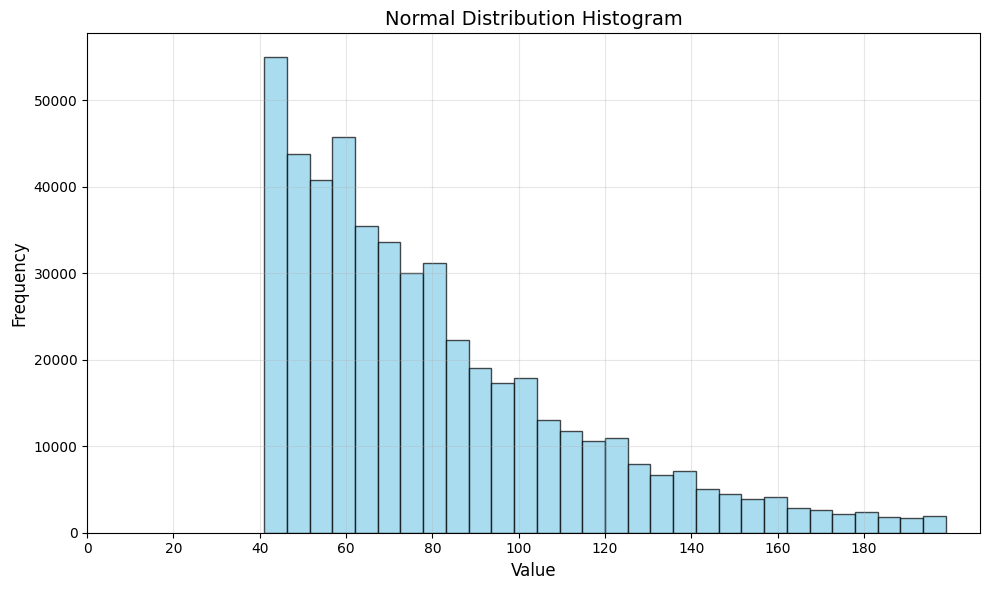

In [33]:
hist_len_sentence(ds_raw, lang = config['lang_tgt'], 
                  min_sentence_len = config['min_sentence_len'], 
                  max_sentence_len = config['max_sentence_len'])

In [34]:
def filter_by_length(dataset, min_len=20, max_len=200):
    def length_filter(example):
        # Check length for all string/list features
        for key, value in example.items():
            if isinstance(value, (str, list)):
                if len(value) < min_len or len(value) > max_len:
                    return False
        return True
    
    filtered_dataset = dataset.filter(length_filter)
    return filtered_dataset

# Usage example: 
filtered_ds_raw = filter_by_length(ds_raw, min_len = config['min_sentence_len'], max_len = config['max_sentence_len'])

Filter: 100%|██████████| 748091/748091 [00:01<00:00, 387020.54 examples/s]


In [35]:
def get_all_sentences(ds, lang):
    for item in ds:
        yield item[lang]

In [36]:
def get_or_build_tokenizer(ds, lang:str,version:str):
    tokenizer_path = Path(config['tokenizer_file'].format(lang,version))
    if not Path.exists(tokenizer_path):
    # if True:
        # Most code taken from: https://huggingface.co/docs/tokenizers/quicktour
        tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordPieceTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer


In [37]:
from torch.utils.data import Dataset

class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair[self.src_lang]
        tgt_text = src_target_pair[self.tgt_lang]

        # Transform the text into tokens
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Add sos, eos and padding to each sentence
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        # We will only add <s>, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")
        # Add <s> and </s> token
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )
        # Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )
        # Add only </s> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )
        # Double check the size of the tensors to make sure they are all seq_len long
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, seq_len)
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }
    
def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

In [38]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)

In [39]:
def beam_search_decode(model, beam_size, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_initial_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    # Create a candidate list
    candidates = [(decoder_initial_input, 1)]

    while True:

        # If a candidate has reached the maximum length, it means we have run the decoding for at least max_len iterations, so stop the search
        if any([cand.size(1) == max_len for cand, _ in candidates]):
            break

        # Create a new list of candidates
        new_candidates = []

        for candidate, score in candidates:

            # Do not expand candidates that have reached the eos token
            if candidate[0][-1].item() == eos_idx:
                continue

            # Build the candidate's mask
            candidate_mask = causal_mask(candidate.size(1)).type_as(source_mask).to(device)
            # calculate output
            out = model.decode(encoder_output, source_mask, candidate, candidate_mask)
            # get next token probabilities
            prob = model.project(out[:, -1])
            # get the top k candidates
            topk_prob, topk_idx = torch.topk(prob, beam_size, dim=1)
            for i in range(beam_size):
                # for each of the top k candidates, get the token and its probability
                token = topk_idx[0][i].unsqueeze(0).unsqueeze(0)
                token_prob = topk_prob[0][i].item()
                # create a new candidate by appending the token to the current candidate
                new_candidate = torch.cat([candidate, token], dim=1)
                # We sum the log probabilities because the probabilities are in log space
                new_candidates.append((new_candidate, score + token_prob))

        # Sort the new candidates by their score
        candidates = sorted(new_candidates, key=lambda x: x[1], reverse=True)
        # Keep only the top k candidates
        candidates = candidates[:beam_size]

        # If all the candidates have reached the eos token, stop
        if all([cand[0][-1].item() == eos_idx for cand, _ in candidates]):
            break

    # Return the best candidate
    return candidates[0][0].squeeze()

In [40]:
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, num_examples=2):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted_greedy = []
    predicted_beam = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            model_out_beam = beam_search_decode(model, 3, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text_beam = tokenizer_tgt.decode(model_out_beam.detach().cpu().numpy())
            model_out_text_greedy = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted_greedy.append(model_out_text_greedy)
            predicted_beam.append(model_out_text_beam)
            
            # Print the source, target and model output
            print_msg('-'*console_width)
            print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED GREEDY: ':>12}{model_out_text_greedy}")
            print_msg(f"{f'PREDICTED BEAM:   ':>12}{model_out_text_beam}")


            if count == num_examples:
                print_msg('-'*console_width)
                break
    
    
    # Evaluate the character error rate
    # Compute the char error rate 
    metric_greedy = torchmetrics.CharErrorRate()
    cer = metric_greedy(predicted_greedy, expected)
    wandb.log({'validation_greedy/cer': cer, 'global_step': global_step})

    # Compute the word error rate
    metric_greedy = torchmetrics.WordErrorRate()
    wer = metric_greedy(predicted_greedy, expected)
    wandb.log({'validation_greedy/wer': wer, 'global_step': global_step})

    # Compute the BLEU metric
    metric_greedy = torchmetrics.BLEUScore()
    bleu = metric_greedy(predicted_greedy, expected)
    wandb.log({'validation_greedy/BLEU': bleu, 'global_step': global_step})

    # Evaluate the character error rate
    # Compute the char error rate 
    metric_beam = torchmetrics.CharErrorRate()
    cer = metric_beam(predicted_beam, expected)
    wandb.log({'validation_beam/cer': cer, 'global_step': global_step})

    # Compute the word error rate
    metric = torchmetrics.WordErrorRate()
    wer = metric_beam(predicted_beam, expected)
    wandb.log({'validation_beam/wer': wer, 'global_step': global_step})

    # Compute the BLEU metric
    metric = torchmetrics.BLEUScore()
    bleu = metric_beam(predicted_beam, expected)
    wandb.log({'validation_beam/BLEU': bleu, 'global_step': global_step})

In [41]:
def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config['seq_len'], d_model=config['d_model'],
        N_layers=config['N_layers'], h = config['heads'], dropout = config['dropout'], d_ff = config['ffn_hidden'])
    return model

In [42]:
def train_model(config,train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt ):
    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
     
    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder'].format(config['version'])}").mkdir(parents=True, exist_ok=True)

    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9, betas = (0.9, 0.98))

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']

    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None

    if model_filename:
    # if False:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    # define our custom x axis metric
    wandb.define_metric("global_step")
    # define which metrics will be plotted against it
    wandb.define_metric("validation_greedy/*", step_metric="global_step")
    wandb.define_metric("validation_beam/*", step_metric="global_step")
    wandb.define_metric("train/*", step_metric="global_step")
    # wandb.define_metric("ln_rate/*", step_metric="global_step")

    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:

            encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))


            # Log the loss
            wandb.log({'train/loss': loss.item(), 'global_step': global_step})

            # Backpropagate the loss
            (loss / config['batch_size']).backward()

            global_step += 1
            
            # Log the loss
            wandb.log({'train/ln_rate': optimizer.param_groups[0]['lr'], 'global_step': global_step})
            if (batch_iterator.n +1) % config['batch_size'] == 0:
                # Update the weights
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                lr_updated = get_lr(step=global_step, d_model=config['d_model'], warmup_steps=config['warmup_steps'])

                change_lr(optimizer, new_lr=lr_updated)
            
            batch_iterator.set_postfix({
                "loss": f"{loss.item():6.3f}",
                'lr' : f"{optimizer.param_groups[0]['lr']:.6g}"
                                        })
            

        # Run validation at the end of every epoch
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

In [43]:
tokenizer_tgt = get_or_build_tokenizer( filtered_ds_raw, config['lang_tgt'],config['version'])
tokenizer_src =  get_or_build_tokenizer( filtered_ds_raw, config['lang_src'],config['version'])

In [44]:
config['vocab_size_tgt'] = tokenizer_tgt.get_vocab_size()
config['vocab_size_src'] = tokenizer_src.get_vocab_size()

In [45]:
train_ds_size = int(0.8 * len(filtered_ds_raw))
val_ds_size = len(filtered_ds_raw) - train_ds_size
train_ds_raw, val_ds_raw = random_split(filtered_ds_raw, [train_ds_size, val_ds_size])


In [46]:
len(filtered_ds_raw)

420646

In [47]:
len(train_ds_raw)

336516

In [48]:
train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, src_lang = config['lang_src'],tgt_lang = config['lang_tgt'], seq_len = config['seq_len'])
val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, src_lang = config['lang_src'],tgt_lang = config['lang_tgt'], seq_len = config['seq_len'])


In [49]:
train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)


In [50]:
if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    config['num_epochs'] = 10
    # config['batch_size'] = 48
    # config['preload'] = None
    wandb.init(
        # set the wandb project where this run will be logged
        project="pytorch-transformer_es_qu{0}".format(config['version']),
        
        # track hyperparameters and run metadata
        config=config
    )
    train_model(config,train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt)

Using device: cuda
Preloading model allenai\nllb_weights_es_qu007\tmodel_es_qu00700.pt


Processing Epoch 01:  47%|████▋     | 4917/10517 [16:16<18:31,  5.04it/s, loss=6.738, lr=0.000711953]


KeyboardInterrupt: 

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [ ]:
# config = get_config()
# train_dataloader, val_dataloader, vocab_src, vocab_tgt = get_ds(config)
model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(config, f"29")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

In [ ]:
def load_next_batch():
    # Load a sample batch from the validation set
    batch = next(iter(val_dataloader))
    encoder_input = batch["encoder_input"].to(device)
    encoder_mask = batch["encoder_mask"].to(device)
    decoder_input = batch["decoder_input"].to(device)
    decoder_mask = batch["decoder_mask"].to(device)

    encoder_input_tokens = [tokenizer_src.id_to_token(idx) for idx in encoder_input[0].cpu().numpy()]
    decoder_input_tokens = [tokenizer_tgt.id_to_token(idx) for idx in decoder_input[0].cpu().numpy()]

    # check that the batch size is 1
    assert encoder_input.size(
        0) == 1, "Batch size must be 1 for validation"

    model_out = greedy_decode(
        model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, config['seq_len'], device)
    
    return batch, encoder_input_tokens, decoder_input_tokens

In [ ]:
import pandas as pd
import altair as alt
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s" % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s" % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        columns=["row", "column", "value", "row_token", "col_token"],
    )

def get_attn_map(attn_type: str, layer: int, head: int):
    if attn_type == "encoder":
        attn = model.encoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "decoder":
        attn = model.decoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "encoder-decoder":
        attn = model.decoder.layers[layer].cross_attention_block.attention_scores
    return attn[0, head].data

def attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len):
    df = mtx2df(
        get_attn_map(attn_type, layer, head),
        max_sentence_len,
        max_sentence_len,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        #.title(f"Layer {layer} Head {head}")
        .properties(height=400, width=400, title=f"Layer {layer} Head {head}")
        .interactive()
    )

def get_all_attention_maps(attn_type: str, layers: list[int], heads: list[int], row_tokens: list, col_tokens, max_sentence_len: int):
    charts = []
    for layer in layers:
        rowCharts = []
        for head in heads:
            rowCharts.append(attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len))
        charts.append(alt.hconcat(*rowCharts))
    return alt.vconcat(*charts)

In [ ]:
batch, encoder_input_tokens, decoder_input_tokens = load_next_batch()
print(f'Source: {batch["src_text"][0]}')
print(f'Target: {batch["tgt_text"][0]}')
sentence_len = encoder_input_tokens.index("[PAD]")

In [ ]:
layers = [0, 1, 2, 3, 4, 5]
heads = [0, 1, 2, 3, 4, 5, 6, 7]

# Encoder Self-Attention
get_all_attention_maps("encoder", layers, heads, encoder_input_tokens, encoder_input_tokens, min(20, sentence_len))


In [ ]:
# Encoder Self-Attention
get_all_attention_maps("decoder", layers, heads, decoder_input_tokens, decoder_input_tokens, min(20, sentence_len))

In [ ]:
# Encoder Self-Attention
get_all_attention_maps("encoder-decoder", layers, heads, encoder_input_tokens, decoder_input_tokens, min(20, sentence_len))